Needed dependencies:

  * q-alchemy-sdk-py
  * jupyter
  * matplotlib
  * pandas
  * scikit-learn
  * tqdm

In [1]:
import sys
import os
from threading import Thread

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from qiskit.quantum_info import Statevector
from qiskit import transpile
from qiskit.circuit.library import Initialize

from q_alchemy.initialize import OptParams
from q_alchemy.qiskit_integration import QAlchemyInitialize

sys.path.append('..')
os.environ["Q_ALCHEMY_API_KEY"] = "<your api key>"

True

In [2]:
def plot_digits(digits, labels, matrix_dim, save_fig=None, fig_size=(20, 10)):
    fig, axes = plt.subplots(nrows=1, ncols=len(digits), figsize=fig_size, squeeze=False)
    for ax, digit, label in zip(axes.reshape(-1), digits, labels):
        ax.set_axis_off()
        image = digit[:int(matrix_dim**2)].reshape(matrix_dim, matrix_dim)
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation='none')
        ax.set_title(label)
    if save_fig is not None:
        fig.savefig(save_fig)
    else:
        plt.show()
    plt.close(fig)

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, parser="auto")

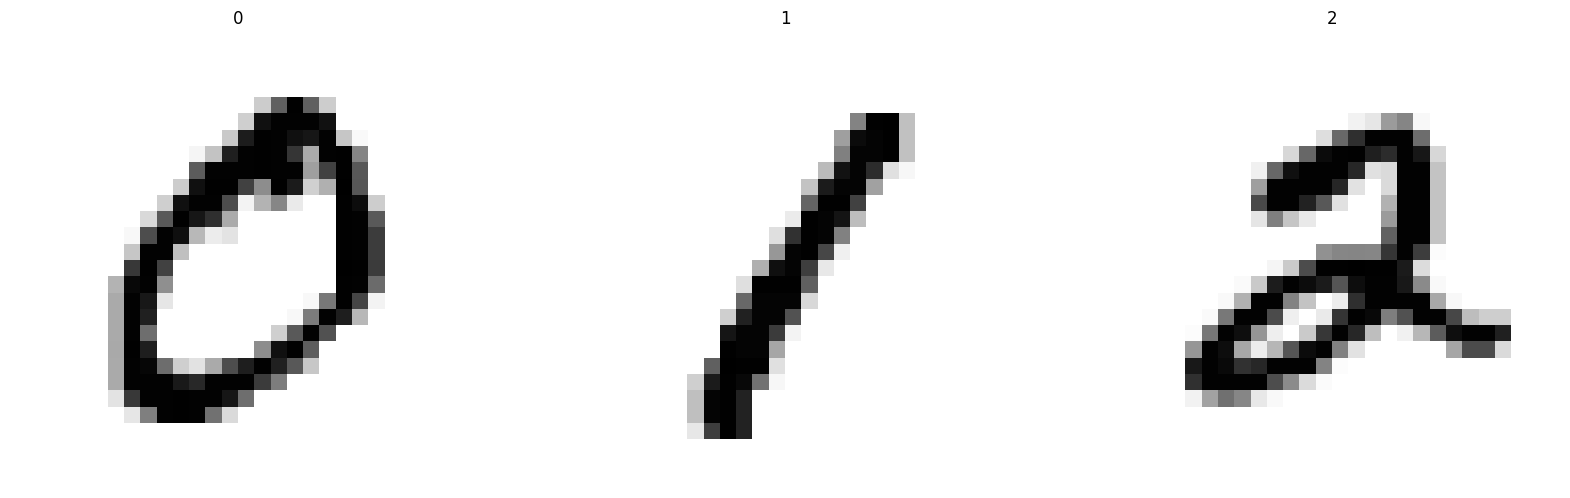

In [4]:
zero: np.ndarray = mnist.data[mnist.target == "0"].iloc[0].to_numpy()
one: np.ndarray = mnist.data[mnist.target == "1"].iloc[0].to_numpy()
two: np.ndarray = mnist.data[mnist.target == "2"].iloc[0].to_numpy()

filler = np.empty(2**10 - zero.shape[0])
filler.fill(0)

zero = np.hstack([zero, filler])
one = np.hstack([one, filler])
two = np.hstack([two, filler])

zero = zero / np.linalg.norm(zero)
one = one / np.linalg.norm(one)
two = two / np.linalg.norm(two)

plot_digits([zero, one, two], [0, 1, 2], 28)

In [5]:
# Here we start a job and you can check it out at the portal: 
# https://portal.q-alchemy.com/dashboard/jobs/explorer?pageIndex=0&pageSize=10&SortBy.SortType=Descending&SortBy.PropertyName=CreatedAt

instr = QAlchemyInitialize(
    params=zero.tolist(), 
    opt_params=OptParams(
        max_fidelity_loss=0.1, 
        basis_gates=["id", "rx", "ry", "rz", "cx"],
        remove_data=False
    ))

In [6]:
instr.definition.draw(fold=-1)

global phase: 0
     ┌──────────────┐  ┌──────────┐          ┌───┐     ┌────────────┐  ┌────────────┐ ┌────────────┐      ┌───┐      ┌─────────────┐ ┌────────────┐ ┌─────────────┐                  ┌───┐     ┌─────────────┐  ┌────────────┐ ┌──────────────┐                                                                                                ┌───┐     ┌────────────┐ ┌────────────┐ ┌────────────┐                                                           ┌───┐┌─────────────┐ ┌────────────┐┌─────────────┐                                               ┌───┐┌────────────┐ ┌────────────┐ ┌──────────────┐     ┌───┐        ┌────────────┐ ┌────────────┐ ┌────────────┐   ┌───┐   ┌─────────────┐  ┌────────────┐ ┌─────────────┐     ┌───┐     ┌─────────────┐                                                                                                                                                                                                                                                                                         ┌───┐    ┌────────────┐ ┌────────────┐ ┌────────────┐                                                  ┌───┐      ┌─────────────┐ ┌────────────┐ ┌─────────────┐                                                     ┌───┐         ┌────────┐  ┌─────────────┐                              ┌───┐┌────────────┐ ┌────────────┐  ┌────────────┐                    ┌───┐     ┌─────────────┐ ┌────────────┐┌─────────────┐                     ┌───┐     ┌──────────────┐┌─────────────┐┌────────────┐                                                                                                                   ┌───┐ ┌────────────┐ ┌────────────┐┌────────────┐                                ┌───┐┌─────────────┐┌────────────┐┌─────────────┐                                 ┌───┐   ┌─────────────┐  ┌────────────┐┌──────────────┐                                                    ┌───┐      ┌────────────┐  ┌────────────┐ ┌────────────┐     ┌───┐     ┌─────────────┐ ┌────────────┐┌─────────────┐                               ┌───┐ ┌────────────┐                                                                                                                                                                                                                                                                     ┌───┐  ┌────────────┐ ┌────────────┐ ┌────────────┐                               ┌───┐    ┌─────────────┐ ┌────────────┐┌─────────────┐                                   ┌───┐     ┌─────────────┐                                                                        ┌───┐      ┌────────────┐ ┌────────────┐  ┌────────────┐                                              ┌───┐┌─────────────┐  ┌────────────┐┌─────────────┐                                            ┌───┐┌──────────────┐┌────────┐     ┌───┐      ┌─────────────┐┌────────────┐ ┌────────────┐ ┌───┐┌─────────────┐  ┌────────────┐  ┌────────────┐                                                                                         ┌───┐┌────────────┐  ┌────────────┐  ┌────────────┐                     ┌───┐      ┌─────────────┐ ┌────────────┐ ┌─────────────┐                   ┌───┐    ┌─────────────┐  ┌────────────┐ ┌─────────────┐      ┌───┐      ┌────────────┐   ┌────────────┐  ┌────────────┐     ┌───┐     ┌─────────────┐ ┌────────────┐ ┌─────────────┐                   ┌───┐       ┌────────────┐                                                                                             ┌───┐      ┌─────────────┐┌────────────┐ ┌────────────┐                               ┌───┐┌─────────────┐ ┌────────────┐ ┌─────────────┐                                                                                                                                                                                                                     ┌───┐      ┌────────────┐  ┌────────────┐ ┌────────────┐      ┌───┐     ┌─────────────┐  ┌────────────┐┌─────────────┐     ┌───┐       ┌────────

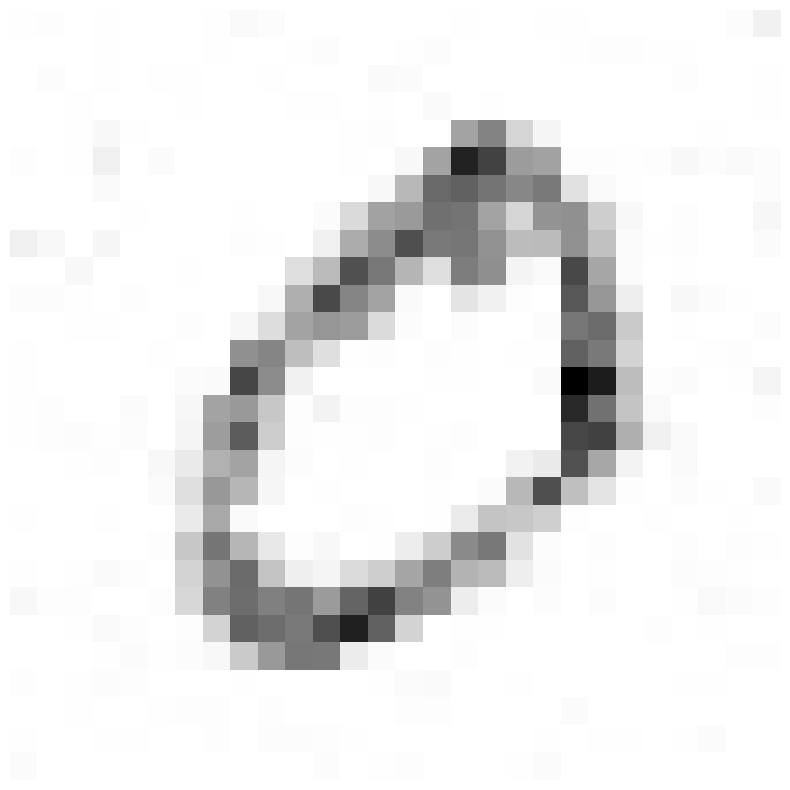

In [7]:
data = Statevector(instr.definition).data
data = np.real(data * data.conj())
plot_digits([data], [""], 28)

# Looking at the 0

In [8]:
from time import sleep

def get_comparison_data(d: np.ndarray):
    
    print("Qiskit Benchmark")
    qs_org = Initialize(d.tolist())
    qs_qc = transpile(qs_org.definition, basis_gates=["id", "rx", "ry", "rz", "cx"])
    state = Statevector(qs_qc).data.copy()
    state = np.real(state * state.conj())
    cx_length = len(qs_qc.get_instructions("cx"))
    
    threads = []
    result = [
        [-1.0, cx_length, state]
    ]
    for fidelity_loss in np.linspace(0.0, 0.2, 10):
        def func(fl):
            fl = np.round(fl, decimals=3)
            sp_org = QAlchemyInitialize(
                params=d.tolist(),
                opt_params=OptParams(
                    max_fidelity_loss=fl, 
                    basis_gates=["id", "rx", "ry", "rz", "cx"]
                )
            )
            qc = sp_org.definition
            sp_length = len(qc.get_instructions("cx"))
            sp_state = Statevector(qc).data.copy()
            sp_state = np.real(sp_state * sp_state.conj())
            result.append([fl, sp_length, sp_state])
        job = Thread(target=func, args=(fidelity_loss,))
        job.start()
        sleep(0.1)  # be easy on the API
        threads.append(job)

    print(f"Waiting for {len(threads)} jobs to finish.")
    for x in tqdm(threads): 
        x.join()
    
    return result

In [9]:
import pandas as pd

def plot_comparison(r):
    meta_data: np.ndarray = np.asarray([r[0:2] for r in r])
    sorting = meta_data[:, 0].argsort()
    meta_data = meta_data[sorting]
    
    image_data: np.ndarray = np.asarray([r[2] for r in r])
    image_data = image_data[sorting]
    
    labels = [f"{r[0]:.2f} @ {r[1]:n}cx" for r in meta_data]
    plot_digits(image_data, labels, 28)
    
    
def plot_comparison_v2(r, name="qa"):
    meta_data: np.ndarray = np.asarray([r[0:2] for r in r])
    sorting = meta_data[:, 0].argsort()
    meta_data = meta_data[sorting]
    
    image_data: np.ndarray = np.asarray([r[2] for r in r])
    image_data = image_data[sorting]
    
    os.makedirs("./mnist784_q-alchemy/", exist_ok=True)
    for meta, imag in zip(meta_data, image_data):
        plot_digits([imag], [""], 28, save_fig=f"./mnist784_q-alchemy/{name}_{meta[0]:.2f} @ {meta[1]:n}cx.svg")
        
    df = pd.DataFrame(
        data=meta_data,
        columns=["Fidelity Loss", "CX-Gate Count"]
    )
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10), squeeze=True)
    df.plot.bar(x="Fidelity Loss", y="CX-Gate Count", ax=ax)
    fig.savefig(f"./mnist784_q-alchemy/{name}.svg")
    plt.close(fig)
    
    return df
        

In [10]:
result_zero = get_comparison_data(zero)

Qiskit Benchmark
Waiting for 10 jobs to finish.


100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


In [11]:
result_one = get_comparison_data(one)

Qiskit Benchmark
Waiting for 10 jobs to finish.


100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


In [12]:
result_two = get_comparison_data(two)

Qiskit Benchmark
Waiting for 10 jobs to finish.


100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


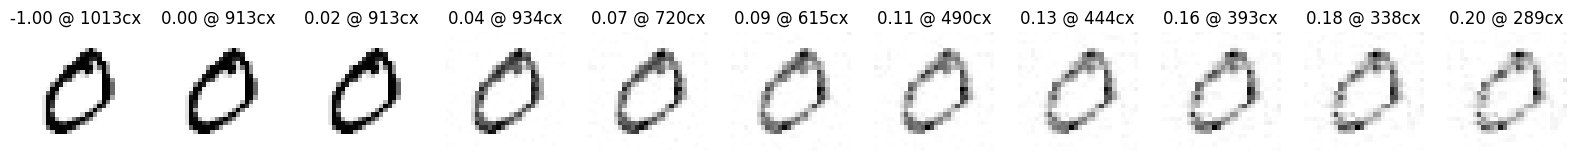

In [13]:
plot_comparison(result_zero)

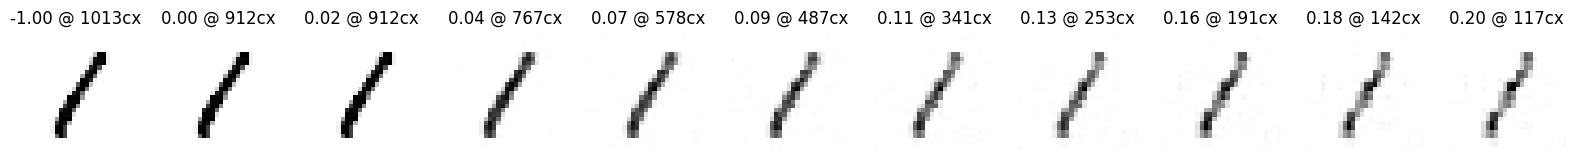

In [14]:
plot_comparison(result_one)

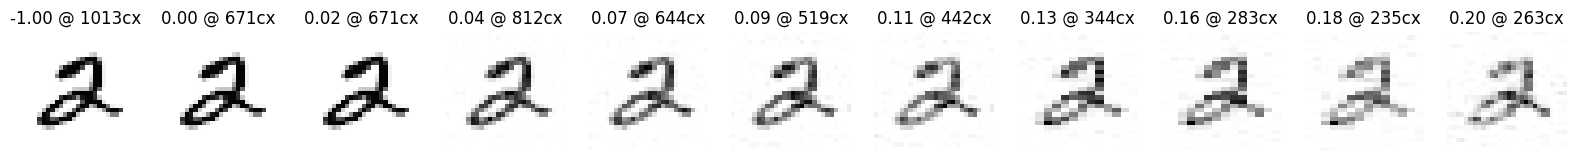

In [15]:
plot_comparison(result_two)